## Multimodal RAG with Weaviate

![images/multimodal_rag.png](images/multimodal_rag.png)

In [22]:
import weaviate
import os

client = weaviate.connect_to_weaviate_cloud(
    cluster_url=os.environ["WCD_TEST_URL"],
    auth_credentials=os.environ["WCD_TEST_KEY"],
    headers = {
        "X-Cohere-Api-Key": os.environ["COHERE_API_KEY"],
        "X-OpenAI-Api-Key": os.environ["OPENAI_API_KEY"],
    },
)

Run the following if you need to delete an existing collection:

In [2]:
# client.collections.delete("Pages")

### Data import

We'll set up a collection where each object is based on a page of a PDF document. 

The vector configuration is set up with: `Configure.MultiVectors.self_provided`

This specifies that it is a multi-vector embedding model (`Configure.MultiVectors`), and that the vectors will be provided by the user (`self-provided`).

In [3]:
from weaviate.classes.config import Property, DataType, Configure, Tokenization

client.collections.create(
    name="Pages",
    properties=[
        Property(
            name="document_title",
            data_type=DataType.TEXT,
        ),
        Property(
            name="page_image",
            data_type=DataType.BLOB,
        ),
        Property(
            name="filename",
            data_type=DataType.TEXT,
            tokenization=Tokenization.FIELD
        ),
    ],
    vector_config=[
        Configure.Vectors.multi2vec_cohere(
            name="page",
            model="embed-v4.0",
            quantizer=Configure.VectorIndex.Quantizer.rq(),
            image_fields=["page_image"]
        )
    ]
)

Now we can load the data into the collection.

In [23]:
pages = client.collections.get("Pages")

To make the process easier, we've pre-generated the embeddings for the pages of the PDF document.

In [ ]:
# import numpy as np
# import json

# with open("data/embeddings/embeddings_metadata.json", "r") as f:
#     metadata = json.load(f)

# embeddings = np.load("data/embeddings/image_embeddings.npy")

In [12]:
from tqdm import tqdm
from pathlib import Path
import base64
from weaviate.util import generate_uuid5


img_files = sorted(Path("data/imgs").glob("*.jpg"))

with pages.batch.fixed_size(batch_size=10) as batch:
    for filepath in tqdm(img_files[:50]):
        image = filepath.read_bytes()
        base64_image = base64.b64encode(image).decode('utf-8')
        obj = {
            "document_title": "Reddit 2024 S1/A",
            "page_image": base64_image,
            "filename": filepath.name
        }

        # Add object to batch for import with (batch.add_object())
        batch.add_object(
            properties=obj,
            uuid=generate_uuid5(filepath.name)
        )

100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


### Queries

Let's try some queries. We'll use the same process as before to generate the query embedding. For convenience, we have defined a utility function `embed_text` that handles the embedding process.

Since we have the embedding to query with (`query_embedding`), we can use the `near_vector` method to find the most relevant pages in the collection.

In [19]:
response = pages.query.near_text(
    query="reddit mission",
    limit=2,
)

for o in response.objects:
    print(f"Filename: {o.properties['filename']}")

Filename: reddit_s1a_010_of_288.jpg
Filename: reddit_s1a_004_of_288.jpg


And we can see which pages come back as the most relevant to the query:

/var/folders/hw/hsnpzf0926n_30_bkr09mb200000gn/T/ipykernel_20761/1123433893.py:11: ResourceWarning: unclosed file <_io.BufferedReader name='data/imgs/reddit_s1a_009_of_288.jpg'>
  img = Image.open(img_path)


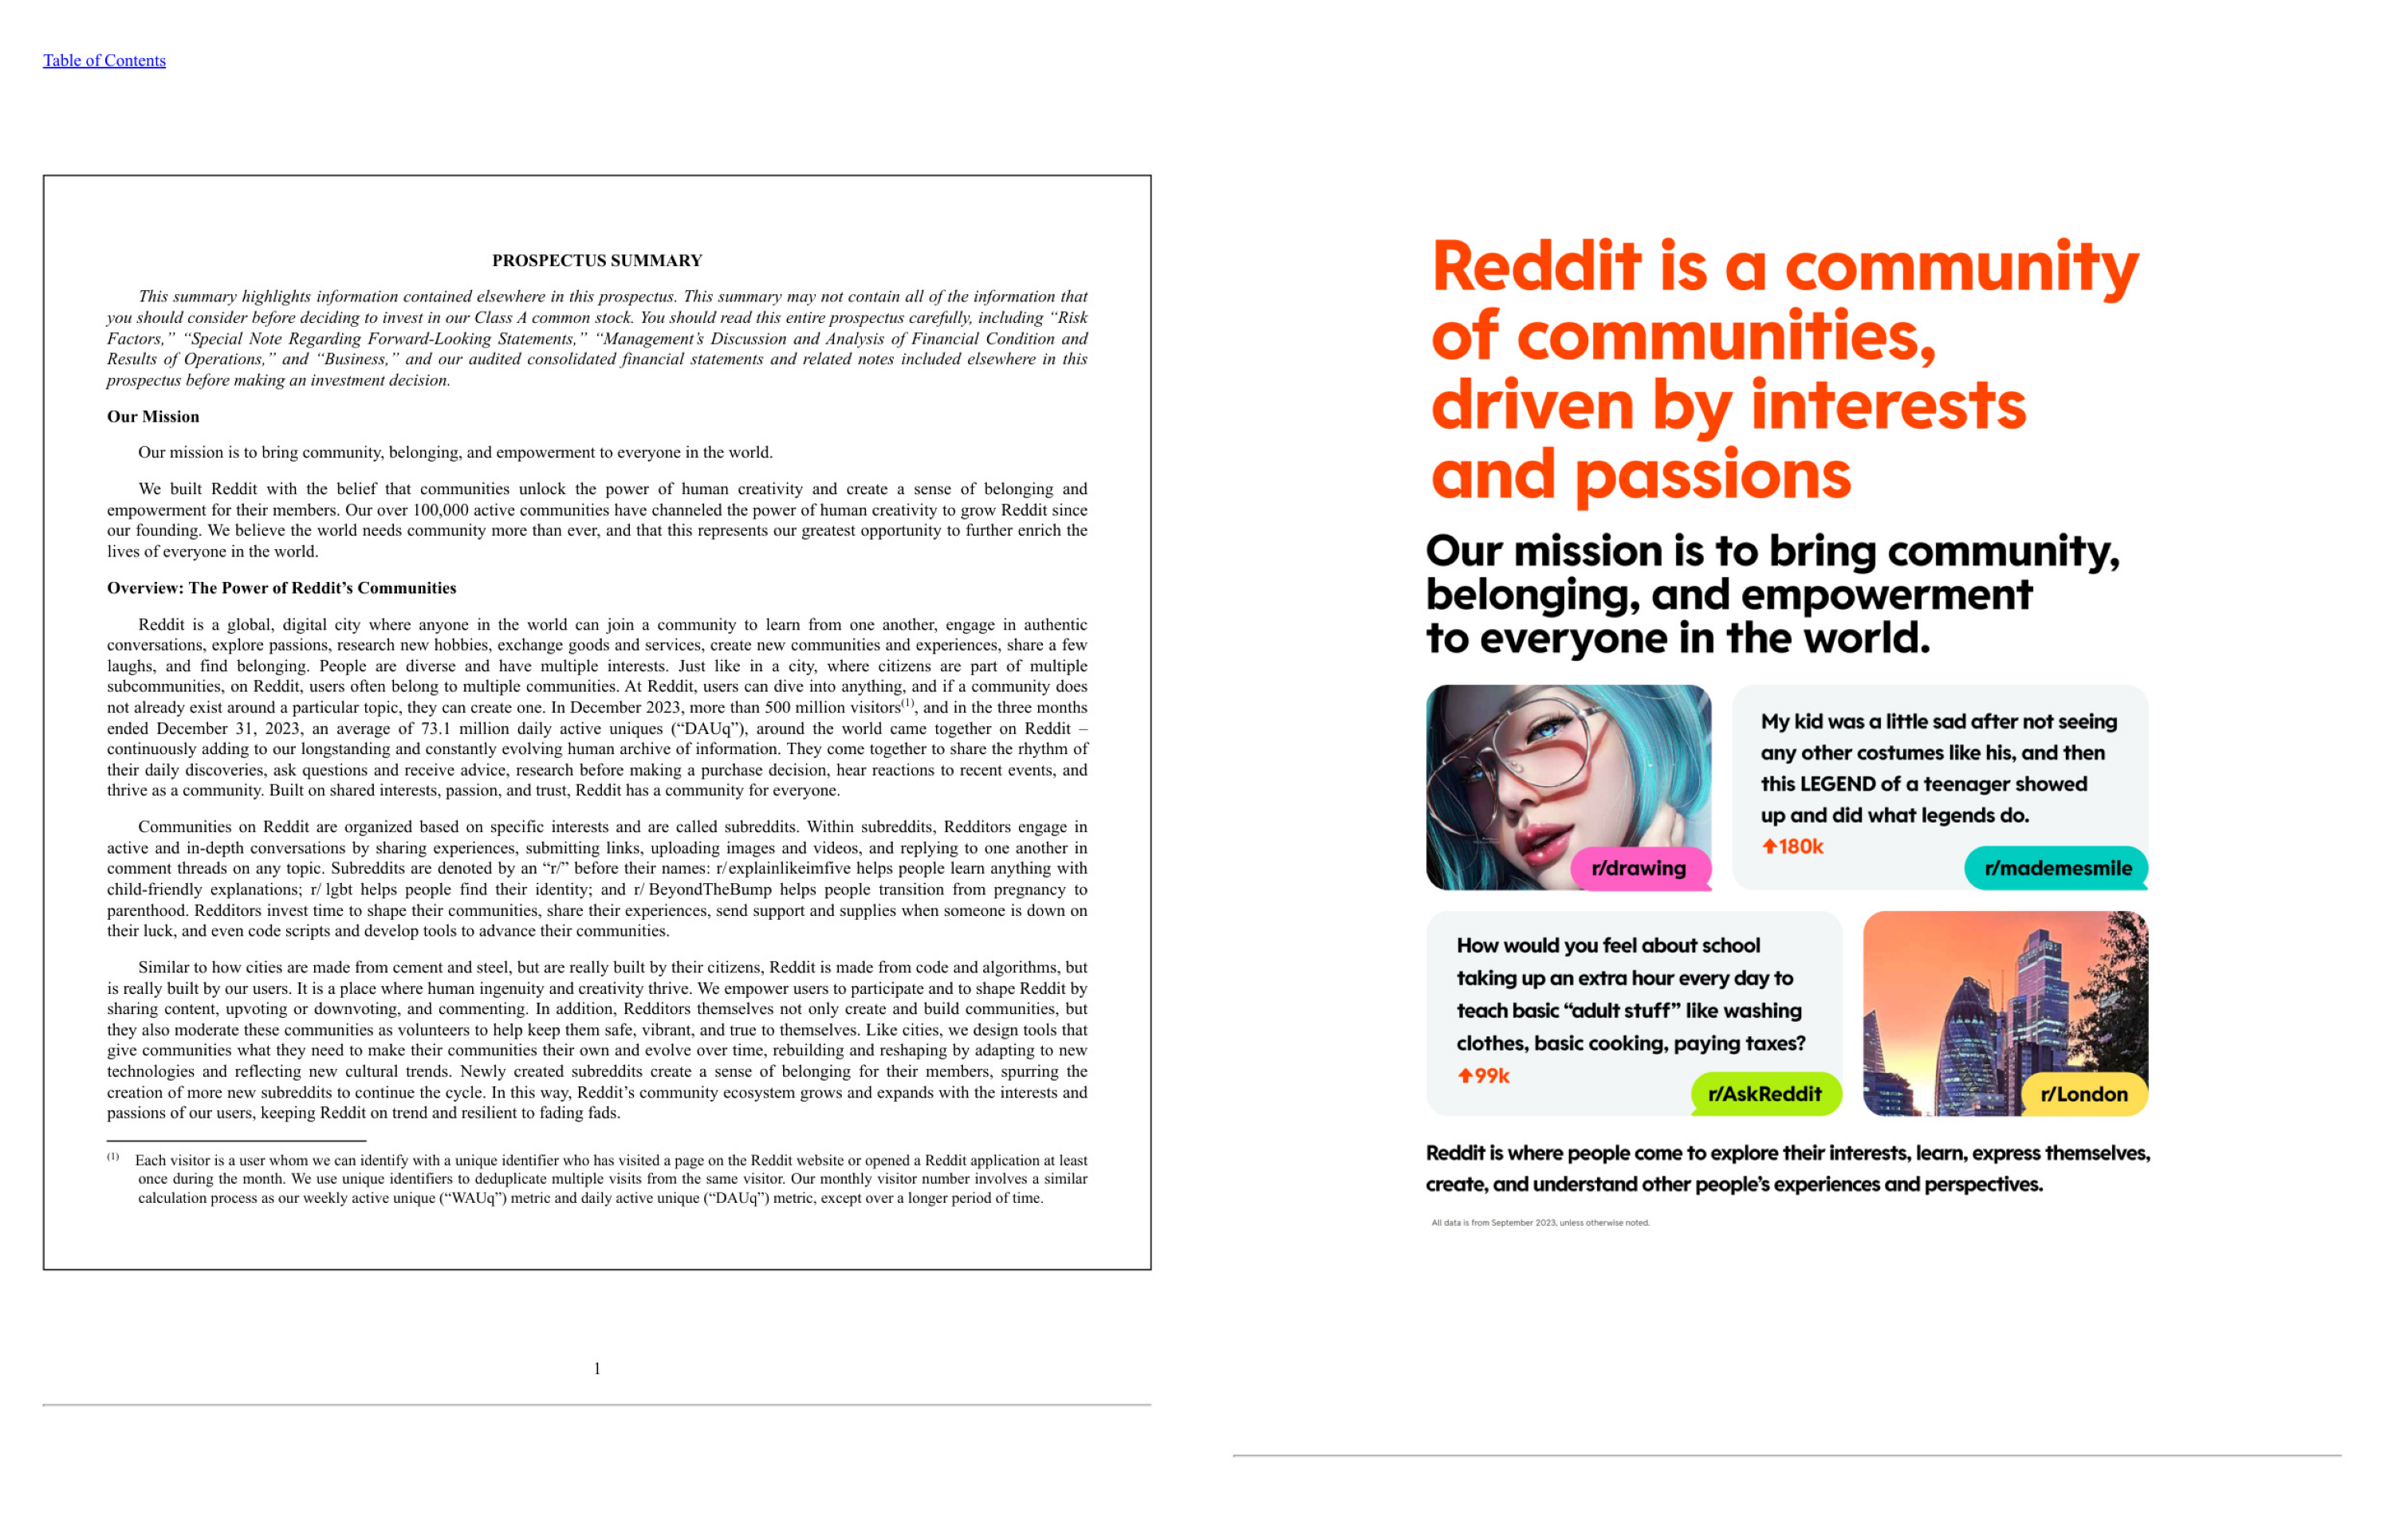

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

images = [
    f"data/imgs/" + o.properties['filename'] for o in response.objects
]

fig, axes = plt.subplots(1, 2, figsize=(30, 40))

for i, img_path in enumerate(images):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Retrieval augmented generation (RAG)

Now, we can combine this workflow with a generative AI model and a prompt to generate a response based on the retrieved pages.

In [ ]:
from weaviate.classes.generate import GenerativeConfig, GenerativeParameters

prompt = GenerativeParameters.grouped_task(
    prompt="What does this say Reddit's mission is?",
    image_properties=["page_image"],  # Property containing images in Weaviate
)

# We use `pages.generate` here to generate a response based on the retrieved pages.
response = pages.generate.near_text(
    query="reddit mission",
    limit=2,
    # These parameters are used to define the RAG task & model
    grouped_task=prompt,
    generative_provider=GenerativeConfig.openai(model="gpt-4o-mini",)
)

And the results are:

In [32]:
print(response.generative.text)

Reddit's mission is to bring community, belonging, and empowerment to everyone in the world. This mission emphasizes the importance of creativity and connection among users through various communities and shared interests.


In [33]:
from weaviate.classes.generate import GenerativeConfig, GenerativeParameters

prompt = GenerativeParameters.grouped_task(
    prompt="What do each of these pages describe?",
    image_properties=["page_image"],  # Property containing images in Weaviate
)

# We use `pages.generate` here to generate a response based on the retrieved pages.
response = pages.generate.near_text(
    query="reddit mission",
    limit=2,
    # These parameters are used to define the RAG task & model
    grouped_task=prompt,
    generative_provider=GenerativeConfig.openai(model="gpt-4o-mini",)
)

print(response.generative.text)

The pages you provided describe the following:

1. **Prospectus Summary Page**: This page outlines Reddit's mission and community structure. It emphasizes that Reddit aims to foster community, belonging, and empowerment. The overview highlights Reddit as a global platform where users can engage in discussions, explore interests, and create communities (subreddits) centered around various topics. It mentions statistics regarding user activity and emphasizes the importance of community-driven content.

2. **Community of Communities Page**: This page reinforces Reddit's mission to provide a space for community, belonging, and empowerment. It uses examples and illustrations of different subreddits (like r/drawing, r/mademesmile, and r/AskReddit) to illustrate how diverse interests and passions are represented on the platform. The page portrays Reddit as a place for individuals to learn, express themselves, and share experiences while navigating different topics and interests. 

Overall, bo

### Close the client

Remember to close the client library connection & Weaviate.

In [34]:
client.close()